# I. Importing the required libraries

In [2]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Users\arjun\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# II. Reading the data

In [7]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'actor', 'gender',
                                'intensity','emotion'])
count = 0
file_list=os.listdir("C:/EmmotionCorrelation-master/frenchdata")
for f in file_list:
        nm = f.split('.')[0].split('-')
        path =  f
        actor = int(nm[0])
        emotion = nm[1]
        statement=int(nm[3])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '1':
            intensity = 0
        else:
            intensity = 1
        
        
        data_df.loc[count] = [path,actor, gender, intensity,emotion]
        count += 1

In [8]:
print (len(data_df))
data_df


443


,path,actor,gender,intensity,emotion
0,01-C-1-1.wav,1,male,0,C
1,01-C-1-2.wav,1,male,1,C
2,01-C-1-3.wav,1,male,1,C
3,01-C-1-4.wav,1,male,1,C
4,01-C-1-5.wav,1,male,1,C
...,...,...,...,...,...
438,12-N-1-2.wav,12,female,1,N
439,12-N-1-3.wav,12,female,1,N
440,12-N-1-4.wav,12,female,1,N
441,12-N-1-5.wav,12,female,1,N


# III. Plotting the audio file's waveform and its spectrogram

In [9]:
filename = data_df.path[400]
print (filename)

samples, sample_rate = librosa.load("C:/EmmotionCorrelation-master/frenchdata"+"/"+data_df.path[400])
sample_rate, samples

11-J-1-6.wav


(22050,
 array([ 1.4040577e-05, -2.2159842e-05, -2.2434794e-04, ...,
         2.4351989e-06, -2.2417148e-06,  0.0000000e+00], dtype=float32))

In [10]:
len(samples), sample_rate

(113424, 22050)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [12]:
sample_rate/ len(samples)

0.1944033008887008

Text(0.5, 0, 'Seconds')

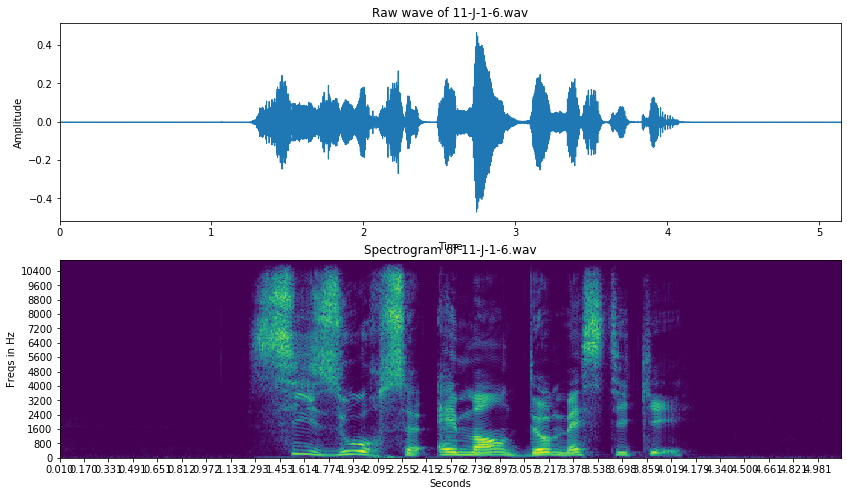

In [13]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [14]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [15]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 1.3812255e-03,  6.6791428e-04, -8.3298224e-04, ...,
        -9.6968826e-05, -4.3040747e-04, -4.2317872e-04], dtype=float32),
 array([27648, 90624]))

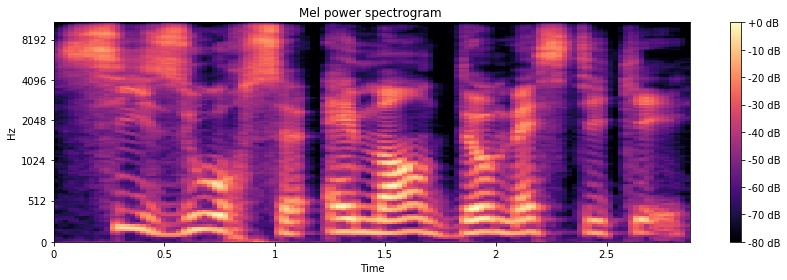

In [16]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

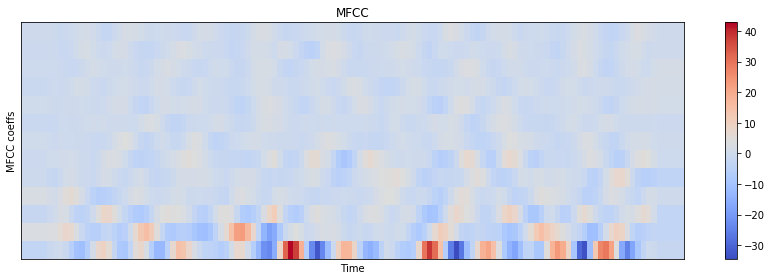

In [17]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [18]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [19]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [20]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [21]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 'N': # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 'J': # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 'T': # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 'C': # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 'P': # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

443

In [23]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [22]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 'N':
        lb = "_calm"
    elif data_df.emotion[i] == 'J':
        lb = "_happy"
    elif data_df.emotion[i] == 'T':
        lb = "_sad"
    elif data_df.emotion[i] == 'C':
        lb = "_angry"
    elif data_df.emotion[i] == 'P':
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

443

In [25]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [23]:
# Select the label set you want by commenting the unwanteds.

#data_df['label'] = label2_list
# data_df['label'] = label3_list
data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,actor,gender,intensity,emotion,label
0,01-C-1-1.wav,1,male,0,C,male_angry
1,01-C-1-2.wav,1,male,1,C,male_angry
2,01-C-1-3.wav,1,male,1,C,male_angry
3,01-C-1-4.wav,1,male,1,C,male_angry
4,01-C-1-5.wav,1,male,1,C,male_angry


In [24]:
print (data_df.label.value_counts().keys())

Index(['female_none', 'female_angry', 'male_angry', 'male_none', 'female_calm',
       'male_happy', 'female_happy', 'male_calm', 'male_sad', 'female_sad'],
      dtype='object')


In [25]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

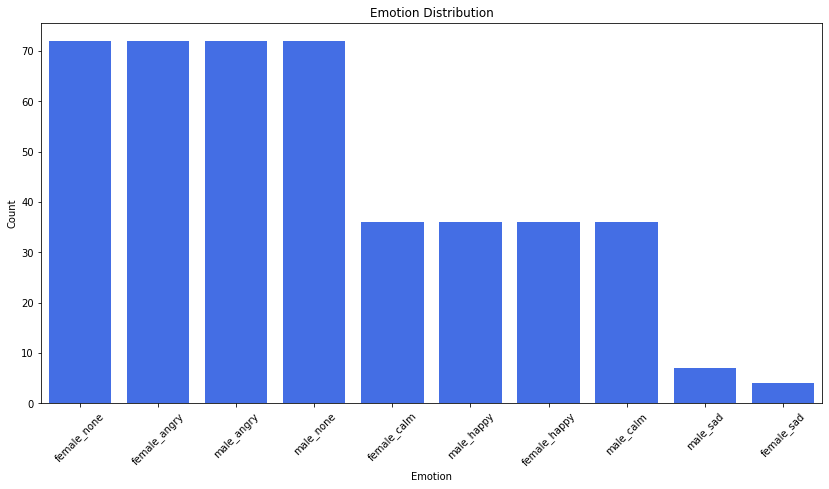

In [26]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [27]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
#data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [28]:
# Male Data Set

## Uncomment all below to use Male set 

#data2_df = data_df.copy()
#data2_df = data2_df[data2_df.label != "male_none"]
#data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
#data2_df = data2_df[data2_df.label != "female_neutral"]
#data2_df = data2_df[data2_df.label != "female_happy"]
#data2_df = data2_df[data2_df.label != "female_angry"]
#data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
#data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

#tmp1 = data2_df[data2_df.actor == 21]
#tmp2 = data2_df[data2_df.actor == 22]
#tmp3 = data2_df[data2_df.actor == 23]
#tmp4 = data2_df[data2_df.actor == 24]
#data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 21]
#data2_df = data2_df[data2_df.actor != 22]
#data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
#print (len(data2_df))
#data2_df.head()

In [29]:
print (len(data2_df))
data2_df.head()

299


,path,actor,gender,intensity,emotion,label
0,01-C-1-1.wav,1,male,0,C,male_angry
1,01-C-1-2.wav,1,male,1,C,male_angry
2,01-C-1-3.wav,1,male,1,C,male_angry
3,01-C-1-4.wav,1,male,1,C,male_angry
4,01-C-1-5.wav,1,male,1,C,male_angry


# VI. Getting the features of audio files using librosa

In [30]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/frenchdata"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:12<00:00, 24.09it/s]


In [31]:
data.head()

,feature
0,"[-40.51034694815409, -39.7213803353069, -35.63..."
1,"[-45.05461298599778, -45.26164605692053, -45.4..."
2,"[-38.91240374171373, -38.788053493252384, -39...."
3,"[-44.90471744945138, -43.23317397880299, -42.1..."
4,"[-37.94450970342854, -38.42915678699059, -38.9..."


In [32]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [33]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-40.510347,-39.721380,-35.630014,-24.705784,-20.050908,-20.306020,-24.251692,-27.719953,-29.142279,-24.872887,...,-37.788055,-38.693966,-38.081660,-36.430135,NaN,NaN,NaN,NaN,NaN,NaN
1,-45.054613,-45.261646,-45.497297,-45.814226,-43.843947,-43.862655,-44.896445,-44.636625,-45.062274,-45.714410,...,-12.342274,-11.131118,-13.774055,-17.064966,-19.269486,-19.526327,-19.462692,-21.454326,-20.431887,-18.815795
2,-38.912404,-38.788053,-39.403935,-39.120317,-37.949039,-38.845490,-39.538662,-39.214734,-38.226010,-38.073853,...,-18.247531,-19.792347,-19.302148,-19.438971,-17.977165,-18.184513,-23.452364,-25.272346,-28.362499,-36.016222
3,-44.904717,-43.233174,-42.134927,-42.343118,-43.173829,-43.524799,-42.554026,-42.304305,-42.553127,-42.622835,...,-19.466813,-19.236907,-23.013510,-24.601166,-14.713429,-14.576524,-20.415013,-19.295489,-18.232522,-21.354322
4,-37.944510,-38.429157,-38.983284,-38.899095,-39.170157,-38.865252,-39.174152,-37.467948,-35.975228,-34.791989,...,-22.976680,-23.830228,-21.390785,-21.203563,-25.311705,-33.112492,-37.914620,-36.770367,-37.338825,-35.369329


In [34]:
newdf = pd.concat([df3,labels], axis=1)

In [35]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

299

In [36]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-40.510347,-39.721380,-35.630014,-24.705784,-20.050908,-20.306020,-24.251692,-27.719953,-29.142279,-24.872887,...,-38.693966,-38.081660,-36.430135,NaN,NaN,NaN,NaN,NaN,NaN,male_angry
1,-45.054613,-45.261646,-45.497297,-45.814226,-43.843947,-43.862655,-44.896445,-44.636625,-45.062274,-45.714410,...,-11.131118,-13.774055,-17.064966,-19.269486,-19.526327,-19.462692,-21.454326,-20.431887,-18.815795,male_angry
2,-38.912404,-38.788053,-39.403935,-39.120317,-37.949039,-38.845490,-39.538662,-39.214734,-38.226010,-38.073853,...,-19.792347,-19.302148,-19.438971,-17.977165,-18.184513,-23.452364,-25.272346,-28.362499,-36.016222,male_angry
3,-44.904717,-43.233174,-42.134927,-42.343118,-43.173829,-43.524799,-42.554026,-42.304305,-42.553127,-42.622835,...,-19.236907,-23.013510,-24.601166,-14.713429,-14.576524,-20.415013,-19.295489,-18.232522,-21.354322,male_angry
4,-37.944510,-38.429157,-38.983284,-38.899095,-39.170157,-38.865252,-39.174152,-37.467948,-35.975228,-34.791989,...,-23.830228,-21.390785,-21.203563,-25.311705,-33.112492,-37.914620,-36.770367,-37.338825,-35.369329,male_angry
5,-43.895131,-42.726484,-41.792518,-42.219679,-43.738356,-43.410168,-42.206327,-42.204671,-43.424694,-42.453413,...,-30.121691,-21.692339,-17.425983,-21.823709,-25.807394,-26.055418,-28.822863,-34.690754,-37.659262,male_angry
6,-52.511814,-52.526480,-52.685870,-52.576093,-52.534564,-51.324431,-50.619788,-49.386290,-41.864182,-30.078103,...,-50.044100,-49.770855,-49.748348,-51.408021,-51.953447,-52.100511,-52.413932,NaN,NaN,male_angry
7,-51.392119,-51.360685,-50.205250,-50.935970,-50.603880,-46.776698,-42.933364,-41.777898,-42.160958,-31.061431,...,-28.121896,-29.459889,-36.374357,-43.685751,-44.538773,-45.457502,-47.552241,-48.338183,-47.975891,male_angry
8,-46.966433,-46.521072,-46.608762,-45.362662,-41.885520,-43.200986,-27.115120,-21.317420,-22.747757,-26.190274,...,-18.033770,-23.914755,-34.730853,-43.057590,-40.137293,-32.264946,-27.761905,-28.449539,-33.049837,male_angry
9,-49.807315,-49.807315,-49.807315,-49.807315,-49.807315,-49.807315,-49.807315,-49.691221,-49.481148,-49.488955,...,-32.893330,-27.291277,-24.845166,-24.091215,-23.127495,-26.575485,-27.063727,-20.723878,-19.222821,male_angry


In [37]:
rnewdf.isnull().sum().sum()

162

In [38]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-40.510347,-39.721380,-35.630014,-24.705784,-20.050908,-20.306020,-24.251692,-27.719953,-29.142279,-24.872887,...,-38.693966,-38.081660,-36.430135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_angry
1,-45.054613,-45.261646,-45.497297,-45.814226,-43.843947,-43.862655,-44.896445,-44.636625,-45.062274,-45.714410,...,-11.131118,-13.774055,-17.064966,-19.269486,-19.526327,-19.462692,-21.454326,-20.431887,-18.815795,male_angry
2,-38.912404,-38.788053,-39.403935,-39.120317,-37.949039,-38.845490,-39.538662,-39.214734,-38.226010,-38.073853,...,-19.792347,-19.302148,-19.438971,-17.977165,-18.184513,-23.452364,-25.272346,-28.362499,-36.016222,male_angry
3,-44.904717,-43.233174,-42.134927,-42.343118,-43.173829,-43.524799,-42.554026,-42.304305,-42.553127,-42.622835,...,-19.236907,-23.013510,-24.601166,-14.713429,-14.576524,-20.415013,-19.295489,-18.232522,-21.354322,male_angry
4,-37.944510,-38.429157,-38.983284,-38.899095,-39.170157,-38.865252,-39.174152,-37.467948,-35.975228,-34.791989,...,-23.830228,-21.390785,-21.203563,-25.311705,-33.112492,-37.914620,-36.770367,-37.338825,-35.369329,male_angry


# VII. Data Augmentation

In [39]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




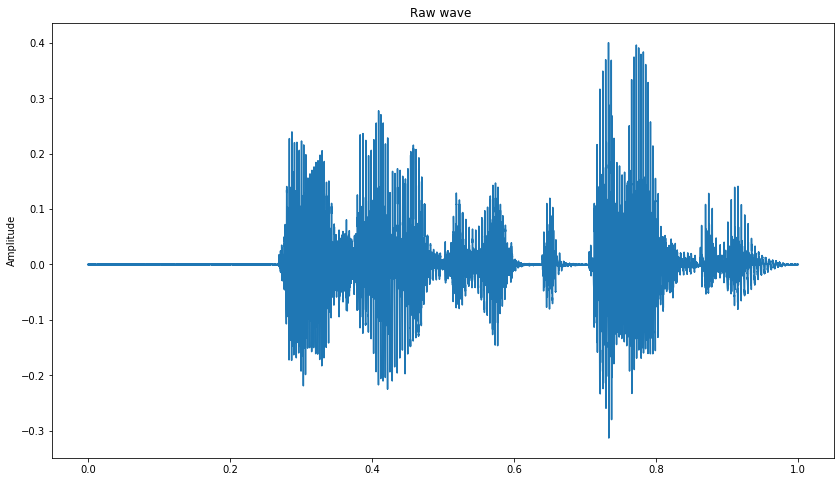

In [41]:
X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/frenchdata"+"/"+data2_df.path[216], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

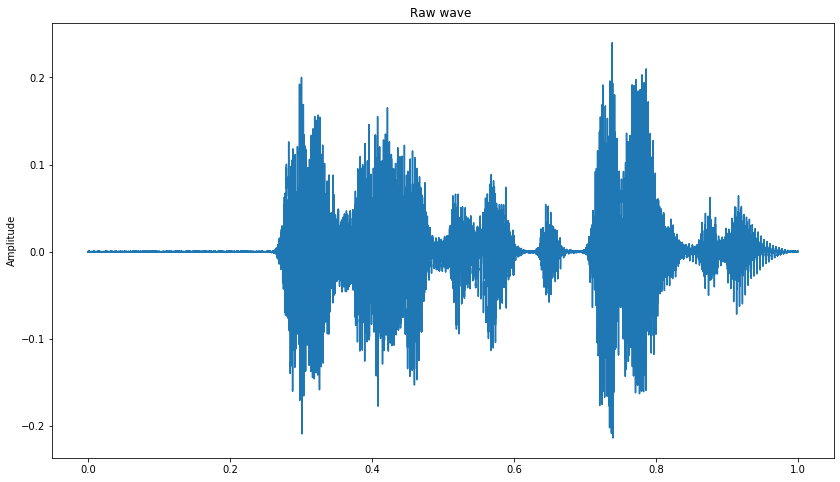

In [46]:
x = pitch(X,sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)  

In [48]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/frenchdata"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:11<00:00, 25.18it/s]


In [49]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/frenchdata"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [00:24<00:00, 11.99it/s]


In [50]:
len(syn_data1), len(syn_data2) 

(299, 299)

In [51]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [52]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

299

In [53]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-39.734145,-38.810861,-34.932176,-24.490418,-20.009659,-20.309694,-24.244516,-27.533763,-28.929816,-24.664249,...,-37.722431,-36.859073,-35.371354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_angry
1,-37.764315,-37.956278,-39.530589,-39.881823,-37.468435,-37.517151,-39.584114,-40.098625,-38.605842,-39.189005,...,-10.704077,-13.362890,-16.828554,-18.799363,-18.908171,-19.386811,-21.263209,-20.291015,-18.823337,male_angry
2,-30.124650,-28.749242,-29.033328,-29.125052,-29.484132,-29.336770,-29.916817,-29.984594,-29.261744,-28.604037,...,-18.698658,-18.436445,-18.277586,-16.950694,-17.305404,-21.166052,-22.132632,-25.443823,-29.608953,male_angry
3,-35.729015,-35.565941,-34.608380,-33.818271,-34.225660,-34.575101,-33.749043,-32.922227,-33.232243,-33.265529,...,-19.183228,-22.533913,-23.827488,-14.396184,-14.271932,-19.474768,-18.562372,-17.636554,-20.803055,male_angry
4,-31.492690,-29.492041,-30.244255,-31.683792,-30.926897,-30.418720,-31.729021,-30.811803,-30.807845,-30.490152,...,-21.999594,-19.746614,-19.952524,-24.481451,-31.563576,-31.060026,-31.475101,-31.578563,-29.639063,male_angry


In [54]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

299

In [55]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-40.160901,-36.818605,-31.831814,-26.542168,-23.601248,-22.775155,-23.948855,-27.939219,-27.791453,-25.008200,...,-42.082889,-41.909514,-43.274965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_angry
1,-45.781050,-46.458224,-47.513772,-47.947343,-46.806122,-47.499574,-48.242340,-49.010786,-48.196765,-47.623010,...,-14.647863,-15.234215,-18.641116,-21.656231,-22.684934,-23.119067,-22.525341,-23.652963,-25.508898,male_angry
2,-39.134623,-39.125022,-40.523909,-41.077865,-40.687067,-40.657964,-41.407304,-40.192277,-39.640295,-40.920679,...,-25.221640,-24.660189,-23.876198,-23.947029,-24.171366,-25.337545,-29.556146,-33.052819,-37.466985,male_angry
3,-46.227411,-44.979845,-46.135152,-48.072876,-48.500464,-48.091138,-47.966447,-47.340881,-48.133681,-48.036709,...,-24.225670,-24.942659,-23.850151,-20.892207,-20.335029,-23.157088,-25.575178,-24.521137,-24.652442,male_angry
4,-38.749719,-39.245208,-41.032037,-41.063663,-41.351224,-41.998728,-41.413929,-39.616196,-38.823887,-37.672891,...,-24.954494,-25.071463,-25.162254,-25.543933,-29.506356,-35.587001,-40.128320,-39.353780,-38.540534,male_angry


In [56]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-40.510347,-39.721380,-35.630014,-24.705784,-20.050908,-20.306020,-24.251692,-27.719953,-29.142279,-24.872887,...,-38.693966,-38.081660,-36.430135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_angry
1,-45.054613,-45.261646,-45.497297,-45.814226,-43.843947,-43.862655,-44.896445,-44.636625,-45.062274,-45.714410,...,-11.131118,-13.774055,-17.064966,-19.269486,-19.526327,-19.462692,-21.454326,-20.431887,-18.815795,male_angry
2,-38.912404,-38.788053,-39.403935,-39.120317,-37.949039,-38.845490,-39.538662,-39.214734,-38.226010,-38.073853,...,-19.792347,-19.302148,-19.438971,-17.977165,-18.184513,-23.452364,-25.272346,-28.362499,-36.016222,male_angry
3,-44.904717,-43.233174,-42.134927,-42.343118,-43.173829,-43.524799,-42.554026,-42.304305,-42.553127,-42.622835,...,-19.236907,-23.013510,-24.601166,-14.713429,-14.576524,-20.415013,-19.295489,-18.232522,-21.354322,male_angry
4,-37.944510,-38.429157,-38.983284,-38.899095,-39.170157,-38.865252,-39.174152,-37.467948,-35.975228,-34.791989,...,-23.830228,-21.390785,-21.203563,-25.311705,-33.112492,-37.914620,-36.770367,-37.338825,-35.369329,male_angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,-35.685421,-34.559336,-33.784539,-34.497476,-34.818689,-35.636232,-35.688640,-35.778752,-35.547409,-36.538008,...,-28.012075,-26.482632,-23.836335,-23.681681,-25.184397,-26.394572,-26.725236,-27.477391,-23.518861,female_calm
893,-27.561791,-28.448520,-30.399044,-31.648964,-32.098650,-31.450838,-28.503086,-25.290164,-21.528529,-20.377230,...,-32.111878,-32.510998,-34.182067,-36.423808,-36.623687,-36.858627,-38.621204,-37.355924,-38.349845,female_calm
894,-30.609897,-30.007885,-30.335380,-31.094263,-28.469864,-27.235849,-28.005519,-30.801249,-31.205791,-30.620279,...,-22.274303,-23.508020,-25.689139,-26.938521,-28.671647,-27.333788,-23.305313,-21.954102,-23.312409,female_calm
895,-28.788869,-29.461119,-29.732702,-28.126968,-28.477316,-30.096392,-30.144055,-29.934351,-29.770838,-31.291474,...,-27.494595,-29.239735,-29.245217,-30.122146,-32.100838,-34.583453,-35.166770,-34.963054,-36.184340,female_calm


In [57]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [58]:
y_train.value_counts()

male_angry      173
female_angry    173
female_happy     86
male_calm        86
female_calm      86
male_happy       86
male_sad         17
female_sad       10
Name: label, dtype: int64

In [59]:
y_test.value_counts()

female_angry    43
male_angry      43
male_happy      22
female_happy    22
female_calm     22
male_calm       22
male_sad         4
female_sad       2
Name: label, dtype: int64

In [60]:
X_train.isna().sum().sum()

0

In [61]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [62]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [63]:
X_train.shape

(717, 65)

# VIII. Changing dimension for CNN model

In [64]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [65]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [66]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [67]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [68]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 65, 256)           2304      
_________________________________________________________________
activation_1 (Activation)    (None, 65, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 256)           524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 65, 256)           1024      
_________________________________________________________________
activation_2 (Activation)    (None, 65, 256)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 65, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)           

In [69]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [70]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('aug_noiseNshift_2class2_np.h5_french', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Train on 717 samples, validate on 180 samples
Epoch 1/700
717/717 [==============================] - 6s 9ms/step - loss: 2.1025 - accuracy: 0.1060 - fscore: 0.0000e+00 - val_loss: 2.0795 - val_accuracy: 0.1222 - val_fscore: 0.0000e+00
Epoch 2/700
717/717 [==============================] - 4s 5ms/step - loss: 2.0940 - accuracy: 0.1255 - fscore: 0.0000e+00 - val_loss: 2.0767 - val_accuracy: 0.1222 - val_fscore: 0.0000e+00
Epoch 3/700
717/717 [==============================] - 3s 4ms/step - loss: 2.0870 - accuracy: 0.1172 - fscore: 0.0000e+00 - val_loss: 2.0751 - val_accuracy: 0.1222 - val_fscore: 0.0000e+00
Epoch 4/700
717/717 [==============================] - 3s 4ms/step - loss: 2.0807 - accuracy: 0.1241 - fscore: 0.0000e+00 - val_loss: 2.0729 - val_accuracy: 0.1167 - val_fscore: 0.0000e+00
Epoch 5/700
717/717 [==============================] - 3s 5ms/step - loss: 2.0765 - accuracy: 0.1185 - fscore: 0.0000e+00 - val_loss: 2.0692 - val_accuracy: 0.1611 - val_fscore: 0.0000e+00
Epoch 6/

Epoch 43/700
717/717 [==============================] - 4s 5ms/step - loss: 1.8545 - accuracy: 0.3417 - fscore: 0.0000e+00 - val_loss: 1.8976 - val_accuracy: 0.3444 - val_fscore: 0.0000e+00
Epoch 44/700
717/717 [==============================] - 4s 5ms/step - loss: 1.8538 - accuracy: 0.3347 - fscore: 0.0000e+00 - val_loss: 1.8935 - val_accuracy: 0.3444 - val_fscore: 0.0000e+00
Epoch 45/700
717/717 [==============================] - 4s 5ms/step - loss: 1.8543 - accuracy: 0.3250 - fscore: 0.0000e+00 - val_loss: 1.8894 - val_accuracy: 0.3444 - val_fscore: 0.0000e+00
Epoch 46/700
717/717 [==============================] - 4s 5ms/step - loss: 1.8488 - accuracy: 0.3375 - fscore: 0.0000e+00 - val_loss: 1.8850 - val_accuracy: 0.3444 - val_fscore: 0.0000e+00
Epoch 47/700
717/717 [==============================] - 4s 6ms/step - loss: 1.8345 - accuracy: 0.3389 - fscore: 0.0000e+00 - val_loss: 1.8806 - val_accuracy: 0.3444 - val_fscore: 0.0000e+00
Epoch 48/700
717/717 [============================

Epoch 87/700
717/717 [==============================] - 3s 5ms/step - loss: 1.6537 - accuracy: 0.3696 - fscore: 0.0920 - val_loss: 1.7261 - val_accuracy: 0.3556 - val_fscore: 0.0000e+00
Epoch 88/700
717/717 [==============================] - 5s 7ms/step - loss: 1.6418 - accuracy: 0.3863 - fscore: 0.1093 - val_loss: 1.7231 - val_accuracy: 0.3611 - val_fscore: 0.0000e+00
Epoch 89/700
717/717 [==============================] - 4s 6ms/step - loss: 1.6390 - accuracy: 0.3640 - fscore: 0.1051 - val_loss: 1.7204 - val_accuracy: 0.3611 - val_fscore: 0.0000e+00
Epoch 90/700
717/717 [==============================] - 4s 5ms/step - loss: 1.6286 - accuracy: 0.3933 - fscore: 0.1186 - val_loss: 1.7170 - val_accuracy: 0.3722 - val_fscore: 0.0000e+00
Epoch 91/700
717/717 [==============================] - 4s 6ms/step - loss: 1.6291 - accuracy: 0.3933 - fscore: 0.1227 - val_loss: 1.7126 - val_accuracy: 0.3778 - val_fscore: 0.0000e+00
Epoch 92/700
717/717 [==============================] - 3s 4ms/step - 

Epoch 176/700
717/717 [==============================] - 4s 5ms/step - loss: 1.3620 - accuracy: 0.4979 - fscore: 0.3101 - val_loss: 1.4840 - val_accuracy: 0.5167 - val_fscore: 0.1194
Epoch 177/700
717/717 [==============================] - 4s 6ms/step - loss: 1.3595 - accuracy: 0.4965 - fscore: 0.3221 - val_loss: 1.4818 - val_accuracy: 0.5111 - val_fscore: 0.1194
Epoch 178/700
717/717 [==============================] - 4s 5ms/step - loss: 1.3651 - accuracy: 0.4840 - fscore: 0.2991 - val_loss: 1.4793 - val_accuracy: 0.5056 - val_fscore: 0.1194
Epoch 179/700
717/717 [==============================] - 4s 6ms/step - loss: 1.3572 - accuracy: 0.4895 - fscore: 0.3230 - val_loss: 1.4771 - val_accuracy: 0.5111 - val_fscore: 0.1194
Epoch 180/700
717/717 [==============================] - 5s 7ms/step - loss: 1.3529 - accuracy: 0.4993 - fscore: 0.3205 - val_loss: 1.4767 - val_accuracy: 0.5111 - val_fscore: 0.1194
Epoch 181/700
717/717 [==============================] - 4s 6ms/step - loss: 1.3396 -

Epoch 221/700
717/717 [==============================] - 3s 4ms/step - loss: 1.2602 - accuracy: 0.5258 - fscore: 0.3978 - val_loss: 1.4071 - val_accuracy: 0.5333 - val_fscore: 0.1765
Epoch 222/700
717/717 [==============================] - 3s 4ms/step - loss: 1.2803 - accuracy: 0.5370 - fscore: 0.3810 - val_loss: 1.4002 - val_accuracy: 0.5389 - val_fscore: 0.1745
Epoch 223/700
717/717 [==============================] - 4s 5ms/step - loss: 1.2620 - accuracy: 0.5258 - fscore: 0.3959 - val_loss: 1.3996 - val_accuracy: 0.5333 - val_fscore: 0.1843
Epoch 224/700
717/717 [==============================] - 3s 5ms/step - loss: 1.2609 - accuracy: 0.5244 - fscore: 0.3910 - val_loss: 1.4007 - val_accuracy: 0.5444 - val_fscore: 0.1765
Epoch 225/700
717/717 [==============================] - 3s 4ms/step - loss: 1.2504 - accuracy: 0.5384 - fscore: 0.3870 - val_loss: 1.3922 - val_accuracy: 0.5444 - val_fscore: 0.1843
Epoch 226/700
717/717 [==============================] - 3s 4ms/step - loss: 1.2465 -

Epoch 266/700
717/717 [==============================] - 4s 6ms/step - loss: 1.1676 - accuracy: 0.5914 - fscore: 0.4471 - val_loss: 1.3305 - val_accuracy: 0.5667 - val_fscore: 0.2436
Epoch 267/700
717/717 [==============================] - 3s 4ms/step - loss: 1.1768 - accuracy: 0.5565 - fscore: 0.4466 - val_loss: 1.3313 - val_accuracy: 0.5667 - val_fscore: 0.2349
Epoch 268/700
717/717 [==============================] - 3s 4ms/step - loss: 1.1615 - accuracy: 0.5788 - fscore: 0.4377 - val_loss: 1.3296 - val_accuracy: 0.5556 - val_fscore: 0.2413
Epoch 269/700
717/717 [==============================] - 3s 5ms/step - loss: 1.1549 - accuracy: 0.5676 - fscore: 0.4452 - val_loss: 1.3333 - val_accuracy: 0.5611 - val_fscore: 0.2164
Epoch 270/700
717/717 [==============================] - 4s 5ms/step - loss: 1.1397 - accuracy: 0.5997 - fscore: 0.4751 - val_loss: 1.3266 - val_accuracy: 0.5556 - val_fscore: 0.2500
Epoch 271/700
717/717 [==============================] - 4s 5ms/step - loss: 1.1713 -

Epoch 311/700
717/717 [==============================] - 3s 4ms/step - loss: 1.0872 - accuracy: 0.6081 - fscore: 0.4735 - val_loss: 1.2723 - val_accuracy: 0.5889 - val_fscore: 0.2789
Epoch 312/700
717/717 [==============================] - 4s 6ms/step - loss: 1.1041 - accuracy: 0.5844 - fscore: 0.4615 - val_loss: 1.2782 - val_accuracy: 0.5778 - val_fscore: 0.2507
Epoch 313/700
717/717 [==============================] - 3s 4ms/step - loss: 1.0676 - accuracy: 0.6109 - fscore: 0.4820 - val_loss: 1.2744 - val_accuracy: 0.5833 - val_fscore: 0.2628
Epoch 314/700
717/717 [==============================] - 3s 4ms/step - loss: 1.0678 - accuracy: 0.6248 - fscore: 0.4970 - val_loss: 1.2770 - val_accuracy: 0.5833 - val_fscore: 0.2726
Epoch 315/700
717/717 [==============================] - 4s 5ms/step - loss: 1.0764 - accuracy: 0.6220 - fscore: 0.4819 - val_loss: 1.2793 - val_accuracy: 0.5833 - val_fscore: 0.2668
Epoch 316/700
717/717 [==============================] - 3s 5ms/step - loss: 1.0899 -

Epoch 400/700
717/717 [==============================] - 3s 5ms/step - loss: 0.9176 - accuracy: 0.6625 - fscore: 0.5654 - val_loss: 1.1823 - val_accuracy: 0.6222 - val_fscore: 0.3651
Epoch 401/700
717/717 [==============================] - 4s 5ms/step - loss: 0.9081 - accuracy: 0.6876 - fscore: 0.5584 - val_loss: 1.2039 - val_accuracy: 0.6333 - val_fscore: 0.3315
Epoch 402/700
717/717 [==============================] - 3s 5ms/step - loss: 0.9077 - accuracy: 0.6876 - fscore: 0.5704 - val_loss: 1.1765 - val_accuracy: 0.6333 - val_fscore: 0.3553
Epoch 403/700
717/717 [==============================] - 3s 5ms/step - loss: 0.9183 - accuracy: 0.6709 - fscore: 0.5676 - val_loss: 1.1767 - val_accuracy: 0.6333 - val_fscore: 0.3663
Epoch 404/700
717/717 [==============================] - 3s 4ms/step - loss: 0.9055 - accuracy: 0.6806 - fscore: 0.5593 - val_loss: 1.1709 - val_accuracy: 0.6333 - val_fscore: 0.3605
Epoch 405/700
717/717 [==============================] - 3s 4ms/step - loss: 0.9168 -

Epoch 445/700
717/717 [==============================] - 3s 5ms/step - loss: 0.8236 - accuracy: 0.7266 - fscore: 0.6268 - val_loss: 1.1179 - val_accuracy: 0.6444 - val_fscore: 0.4265
Epoch 446/700
717/717 [==============================] - 4s 5ms/step - loss: 0.8512 - accuracy: 0.7015 - fscore: 0.6146 - val_loss: 1.1375 - val_accuracy: 0.6333 - val_fscore: 0.4178
Epoch 447/700
717/717 [==============================] - 3s 4ms/step - loss: 0.8196 - accuracy: 0.7071 - fscore: 0.6281 - val_loss: 1.1214 - val_accuracy: 0.6389 - val_fscore: 0.4262
Epoch 448/700
717/717 [==============================] - 3s 4ms/step - loss: 0.8370 - accuracy: 0.7043 - fscore: 0.6213 - val_loss: 1.0985 - val_accuracy: 0.6444 - val_fscore: 0.4373
Epoch 449/700
717/717 [==============================] - 3s 5ms/step - loss: 0.8527 - accuracy: 0.6946 - fscore: 0.5989 - val_loss: 1.1168 - val_accuracy: 0.6500 - val_fscore: 0.4262
Epoch 450/700
717/717 [==============================] - 4s 5ms/step - loss: 0.8181 -

Epoch 490/700
717/717 [==============================] - 3s 4ms/step - loss: 0.7451 - accuracy: 0.7601 - fscore: 0.6845 - val_loss: 1.0494 - val_accuracy: 0.6444 - val_fscore: 0.4756
Epoch 491/700
717/717 [==============================] - 3s 4ms/step - loss: 0.7495 - accuracy: 0.7448 - fscore: 0.6682 - val_loss: 1.0934 - val_accuracy: 0.6556 - val_fscore: 0.4726
Epoch 492/700
717/717 [==============================] - 3s 4ms/step - loss: 0.7481 - accuracy: 0.7643 - fscore: 0.6751 - val_loss: 1.0890 - val_accuracy: 0.6667 - val_fscore: 0.4891
Epoch 493/700
717/717 [==============================] - 3s 5ms/step - loss: 0.7575 - accuracy: 0.7378 - fscore: 0.6711 - val_loss: 1.0621 - val_accuracy: 0.6833 - val_fscore: 0.4880
Epoch 494/700
717/717 [==============================] - 4s 6ms/step - loss: 0.7447 - accuracy: 0.7615 - fscore: 0.6642 - val_loss: 1.1240 - val_accuracy: 0.6500 - val_fscore: 0.4136
Epoch 495/700
717/717 [==============================] - 4s 5ms/step - loss: 0.7676 -

Epoch 535/700
717/717 [==============================] - 3s 4ms/step - loss: 0.6976 - accuracy: 0.7755 - fscore: 0.7151 - val_loss: 1.0639 - val_accuracy: 0.6611 - val_fscore: 0.5062
Epoch 536/700
717/717 [==============================] - 3s 5ms/step - loss: 0.6932 - accuracy: 0.7838 - fscore: 0.7122 - val_loss: 1.0974 - val_accuracy: 0.6444 - val_fscore: 0.4926
Epoch 537/700
717/717 [==============================] - 4s 6ms/step - loss: 0.7373 - accuracy: 0.7545 - fscore: 0.6941 - val_loss: 1.0990 - val_accuracy: 0.6333 - val_fscore: 0.4825
Epoch 538/700
717/717 [==============================] - 3s 4ms/step - loss: 0.7011 - accuracy: 0.7810 - fscore: 0.7020 - val_loss: 1.0526 - val_accuracy: 0.6611 - val_fscore: 0.5133
Epoch 539/700
717/717 [==============================] - 4s 5ms/step - loss: 0.7076 - accuracy: 0.7824 - fscore: 0.7041 - val_loss: 1.1015 - val_accuracy: 0.6333 - val_fscore: 0.4693
Epoch 540/700
717/717 [==============================] - 3s 5ms/step - loss: 0.7133 -

Epoch 624/700
717/717 [==============================] - 4s 6ms/step - loss: 0.6134 - accuracy: 0.7992 - fscore: 0.7601 - val_loss: 1.0231 - val_accuracy: 0.6444 - val_fscore: 0.5504
Epoch 625/700
717/717 [==============================] - 4s 5ms/step - loss: 0.5738 - accuracy: 0.8243 - fscore: 0.7818 - val_loss: 1.0389 - val_accuracy: 0.6556 - val_fscore: 0.5456
Epoch 626/700
717/717 [==============================] - 4s 6ms/step - loss: 0.5793 - accuracy: 0.8285 - fscore: 0.7932 - val_loss: 0.9840 - val_accuracy: 0.6778 - val_fscore: 0.5799
Epoch 627/700
717/717 [==============================] - 3s 5ms/step - loss: 0.5897 - accuracy: 0.8159 - fscore: 0.7896 - val_loss: 0.9896 - val_accuracy: 0.6889 - val_fscore: 0.5810
Epoch 628/700
717/717 [==============================] - 4s 5ms/step - loss: 0.6051 - accuracy: 0.8103 - fscore: 0.7700 - val_loss: 0.9857 - val_accuracy: 0.6778 - val_fscore: 0.5761
Epoch 629/700
717/717 [==============================] - 4s 5ms/step - loss: 0.6090 -

In [71]:
# Plotting the Train Valid Loss Graph
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

NameError: name 'loaded_model' is not defined

## Saving the model

In [62]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [63]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk

accuracy: 86.33%


# X. Predicting emotions on the test data

In [104]:
feeling_list_french=[]
work_dir_french='C:/EmmotionCorrelation-master/French'
my_list_french=os.listdir(work_dir_french)


In [105]:
feeling_list_french=[]
for item in my_list_french:
    if item[3:4]=='C' and int(item[0:2])%2==0:
        feeling_list_french.append('female_angry')
    elif item[3:4]=='C' and int(item[0:2])%2==1:
        feeling_list_french.append('male_angry')
    
    if item[3:4]=='D' and int(item[0:2])%2==0:
        feeling_list_french.append('female_disgust')
    elif item[3:4]=='D' and int(item[0:2])%2==1:
        feeling_list_french.append('male_disgust')
     
    if item[3:4]=='J' and int(item[0:2])%2==0:
        feeling_list_french.append('female_happy')
    elif item[3:4]=='J' and int(item[0:2])%2==1:
        feeling_list_french.append('male_happy')
    
    
    if item[3:4]=='N' and int(item[0:2])%2==0:
        feeling_list_french.append('female_calm')
    elif item[3:4]=='N' and int(item[0:2])%2==1:
        feeling_list_french.append('male_calm')
    
    if item[3:4]=='P' and int(item[0:2])%2==0:
        feeling_list_french.append('female_fear')
    elif item[3:4]=='P' and int(item[0:2])%2==1:
        feeling_list_french.append('male_fear')
    
    if item[3:4]=='S' and int(item[0:2])%2==0:
        feeling_list_french.append('female_surprise')
    elif item[3:4]=='S' and int(item[0:2])%2==1:
        feeling_list_french.append('male_surprise')
        
    if item[3:4]=='T' and int(item[0:2])%2==0:
        feeling_list_french.append('female_sad')
    elif item[3:4]=='T' and int(item[0:2])%2==1:
        feeling_list_french.append('male_sad')
feeling_list_french=np.array(feeling_list_french)

In [112]:
my_list_french=pd.Series(my_list_french,name='filename')
feeling_list_french=pd.Series(feeling_list_french,name='feeling')
french=pd.concat([my_list_french,feeling_list_french],axis=1)
french
#calm
#happy
#sad
#angry
french.filename[2]

'01-D-2-1.wav'

In [114]:
french=french[french.feeling!='male_disgust']
french=french[french.feeling!='female_disgust']
french=french[french.feeling!='male_surprise']
french=french[french.feeling!='male_fear']
french=french[french.feeling!='female_surprise']
french=french[french.feeling!='female_fear']
french=french.reset_index()
data_test = pd.DataFrame(columns=['feature'])

for i in range(len(french)):
    X, sample_rate = librosa.load(work_dir_french+'/'+french.filename[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
#     X = X[10000:90000]
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(french.feeling)
test_valid_lb


array(['male_angry', 'male_angry', 'male_happy', 'male_happy',
       'male_calm', 'male_calm', 'male_sad', 'male_sad', 'female_angry',
       'female_angry', 'female_happy', 'female_happy', 'female_calm',
       'female_calm', 'female_sad', 'female_sad', 'male_angry',
       'male_angry', 'male_happy', 'male_happy', 'male_calm', 'male_calm',
       'male_sad', 'male_sad', 'female_angry', 'female_angry',
       'female_happy', 'female_happy', 'female_calm', 'female_calm',
       'female_sad', 'female_sad', 'male_angry', 'male_angry',
       'male_happy', 'male_happy', 'male_calm', 'male_calm', 'male_sad',
       'male_sad', 'female_angry', 'female_angry', 'female_happy',
       'female_happy', 'female_calm', 'female_calm', 'female_sad',
       'female_sad'], dtype=object)

In [115]:
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

In [116]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

48/48 [==============================] - 0s 5ms/step


In [117]:
preds

array([[7.24437609e-02, 3.71873379e-01, 3.51563916e-02, 9.41767618e-02,
        1.72229037e-02, 4.47345944e-03, 2.04717112e-03, 4.02606159e-01],
       [1.77447096e-01, 6.18967175e-01, 2.54974756e-02, 6.97693750e-02,
        9.49908234e-03, 2.83353240e-03, 1.13171176e-03, 9.48546082e-02],
       [2.25406438e-02, 1.51631579e-01, 1.67568579e-01, 6.56187594e-01,
        1.09760018e-04, 1.33050241e-06, 3.39965554e-05, 1.92656880e-03],
       [1.10693658e-02, 2.98766028e-02, 3.46637778e-02, 8.84515345e-01,
        3.17523009e-05, 3.86503780e-05, 6.33408723e-04, 3.91711444e-02],
       [5.77989146e-02, 1.04677965e-04, 1.58742059e-03, 2.46517430e-03,
        6.29782025e-03, 1.53751737e-02, 8.46874237e-01, 6.94965646e-02],
       [1.99179724e-01, 3.31936739e-02, 2.56269146e-02, 6.18477948e-02,
        4.32316251e-02, 6.02902807e-02, 1.53091758e-01, 4.23538297e-01],
       [3.73536319e-01, 4.34062304e-03, 5.32871664e-01, 6.91665486e-02,
        2.33976590e-03, 1.83134798e-05, 7.12372130e-03, 1.

In [118]:
preds1=preds.argmax(axis=1)

In [119]:
preds1

array([7, 1, 3, 3, 6, 7, 2, 7, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 7, 1, 7, 4,
       3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 0, 7, 7, 3, 0, 0, 3, 3, 3, 3, 3, 1,
       1, 3, 3, 1], dtype=int64)

In [120]:
abc = preds1.astype(int).flatten()

In [121]:
predictions = (lb.inverse_transform((abc)))

In [122]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_sad
1,female_calm
2,female_sad
3,female_sad
4,male_happy
5,male_sad
6,female_happy
7,male_sad
8,female_sad
9,female_sad


In [123]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [124]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_angry
2,male_happy
3,male_happy
4,male_calm
5,male_calm
6,male_sad
7,male_sad
8,female_angry
9,female_angry


In [125]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [127]:
finaldf

,actualvalues,predictedvalues
0,male_angry,male_sad
1,male_angry,female_calm
2,male_happy,female_sad
3,male_happy,female_sad
4,male_calm,male_happy
5,male_calm,male_sad
6,male_sad,female_happy
7,male_sad,male_sad
8,female_angry,female_sad
9,female_angry,female_sad


In [128]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,6
female_calm,6
female_happy,6
female_sad,6
male_angry,6
male_calm,6
male_happy,6
male_sad,6


In [129]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,4
female_calm,12
female_happy,1
female_sad,22
male_angry,1
male_happy,1
male_sad,7


In [130]:
finaldf.to_csv('Predictions.csv', index=False)

In [131]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [132]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

16.666666666666664

In [133]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

10.157203907203908

In [134]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[0, 0, 0, 6, 0, 0, 0, 0],
       [0, 4, 0, 2, 0, 0, 0, 0],
       [0, 1, 0, 5, 0, 0, 0, 0],
       [0, 3, 0, 3, 0, 0, 0, 0],
       [1, 3, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 1, 0, 1, 2],
       [0, 1, 0, 3, 0, 0, 0, 2],
       [1, 0, 1, 3, 0, 0, 0, 1]], dtype=int64)

In [135]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

ValueError: Shape of passed values is (8, 8), indices imply (2, 2)